In [1]:
import sys
import os
import pandas
import numpy as np 
from rdkit import Chem
sys.path.append("../")
import mol_cv
import load_medchem_data
import predict_medchem

fda = load_medchem_data.load_fda_drugs(limit=50)

In [2]:
predictor_dict = predict_medchem.all_predictors()

In [3]:
mol = list(fda["mol"])[0]
smiles = Chem.MolToSmiles(mol)
row = {}
for prop,pred in predictor_dict.items():
    row[prop] = pred.predict_mols([mol])[0]
for k,func in mol_cv._name_to_funcs().items():
    row[k] = func(mol)
lilly = mol_cv._smiles_to_lilly([smiles])[0]
for lilly_prop in ["Status","Demerits","Explanation"]:
    row[f"Lilly {lilly_prop.lower()}"] = lilly[lilly_prop]
row["cns_mpo"] = mol_cv.cns_mpo(log_p=row["log_p"],
                                log_d=row["log_d"],
                                mw=row["Molecular weight"],
                                tpsa=row["Topological polar surface area"],
                                hbd=row["H-bond donors"],
                                pk_a=row["pk_a"])
# see https://en.wikipedia.org/wiki/Lipinski%27s_rule_of_five
row["Lipinski violations"] = sum(((row["log_p"] > 5),(row["Molecular weight"] > 500),(row["H-bond donors"] > 5),(row["H-bond acceptors"] > 5)))
row

{'log_p': np.float32(0.30038044),
 'log_d': np.float32(0.624117),
 'pk_a': np.float32(6.626984),
 'log_s': np.float32(-0.64957815),
 'H-bond donors': 3,
 'H-bond acceptors': 3,
 'Exact mass': 163.030314148,
 'Molecular weight': 163.198,
 'Heavy atom count': 10,
 'Topological polar surface area': 66.4,
 'Rotatable bonds': 3,
 'Chemical formula': 'C5H9NO3S',
 'QED': 0.4915427134370949,
 'Lilly status': 'Reject',
 'Lilly demerits': 100,
 'Lilly explanation': 'thiol:no_rings',
 'cns_mpo': 5.166666666666667,
 'Lipinski violations': np.int64(0)}

In [7]:
name_vals_bad = [
    ["Lipinski/5",row['Lipinski violations']/5],
    ["Deremits (100s)",row['Lilly demerits']/100],
]

name_vals_good = [ 
                ["CNS MPO/6",row["cns_mpo"]/6],
                ["QED",row["QED"]],
            ]

In [11]:

all_vals = name_vals_good + name_vals_bad
r = [ v[1] for v in all_vals]
theta = 2 * np.pi * np.linspace(0,1,num=len(all_vals),endpoint=False)
r,theta

([0.8611111111111112, 0.4915427134370949, np.float64(0.0), 1.0],
 array([0.        , 1.57079633, 3.14159265, 4.71238898]))

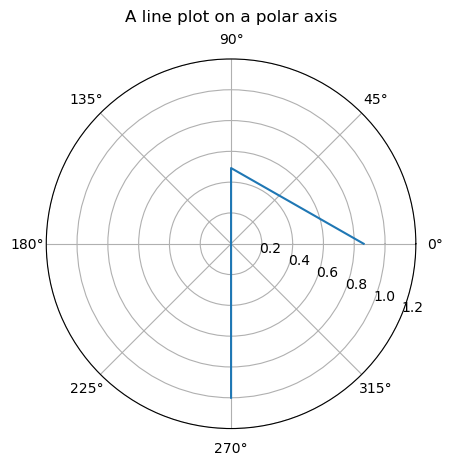

In [13]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, r)
ax.set_rmax(max(r)*1.2)
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()